In [8]:
import csv
import cv2
import sklearn
import numpy as np
from sklearn.utils import shuffle
from keras.layers import pooling
from keras.models import Sequential 
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers import Dropout
from keras.layers import Cropping2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data pre-processing

In [22]:
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
#         print(line[0])
        lines.append(line)
    lines = lines[1:]

# path = './data/'
# get_None_idx = []
# for idx, line in enumerate(lines):
#     line[1] = line[1][1:]
#     line[2] = line[2][1:]
#     if cv2.imread(path + line[0]) is None:
#         get_None_idx.append(idx)
    
#     if cv2.imread(path + line[1]) is None:
#         get_None_idx.append(idx)
        
#     if cv2.imread(path + line[2]) is None:
#         get_None_idx.append(idx)
    
# images = []
# measurments = []
# for line in lines:
#     # Create train_X
#     # read in images from center, left and right cameras    
#     image_center = cv2.imread(path + line[0]) # load the center_image
#     image_left = cv2.imread(path + line[1]) # load the left_image
#     image_right = cv2.imread(path + line[2]) # load the right_image
    
#     # append every image to images list
#     images.extend((image_center, image_left, image_right)) 
    
#     # Create train_Y
#     steering_center = float(line[3])# steering measurment
#     # create adjusted steering measurements for the side camera images
#     correction = 0.2 # this is a parameter to tune
#     steering_left = steering_center + correction
#     steering_right = steering_center - correction
    
#     measurments.extend((steering_center, steering_left, steering_right))
    
# images = np.array(images)
# measurments = np.array(measurments)

# # Data augumentation: flip image in order to let it includes both clockwise and counter-clockwise images
# flip_images = []
# measurments_flipped = []
# for image, measurement in zip(images, measurements):
#     flip_images.append(np.fliplr(image))
#     measurments_flipped.append(-measurement)
# flip_images = np.array(flip_images)
# measurments_flipped = np.array(measurments_flipped)

# train_X = np.array(np.concatenate([images, flip_images], axis=0))
# train_Y = np.array(np.concatenate([measurments, measurments_flipped], axis=0))

# # train, validation split
# train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [44]:
angle = []
for ii in lines:
    angle.append(float(ii[3]))

In [49]:
count_0 = 0
for i in angle:
    if i == 0.0:
        count_0 += 1 
count_0

4361

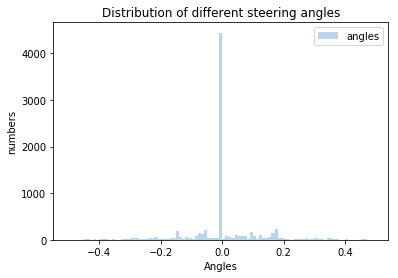

In [56]:
# Histgram
bins = np.arange(-0.5, 0.5, 0.01)

plt.hist(angle, bins=bins, alpha=0.3, label='angles')
# plt.hist(np.concatenate([L2_label_1_full,L2_label_1_test_full],axis=0), bins=bins, alpha=0.3, label='label_1')
# plt.hist(y_test, bins=bins, alpha=0.3, label='y_test')
plt.title('Distribution of different steering angles')
plt.ylabel('numbers')
plt.xlabel('Angles')
plt.legend(loc='upper right')
 
plt.show()

In [60]:
lines[0][0]

'IMG/center_2016_12_01_13_30_48_287.jpg'

# cut angle zero data

In [69]:
# pick up the data with zero steer angles
zero_angle_idx = []
non_zero_angle_idx = []
for idx, ag in enumerate(angle):
    if ag == 0.0:
        zero_angle_idx.append(idx)
    else:
        non_zero_angle_idx.append(idx)

In [70]:
# pick up the center images path that with zero angles
center_with_zero_list = []
for zero_idx in zero_angle_idx:
    center_with_zero_list.append([lines[zero_idx][0], 0.0])

In [79]:
# pick up the center and side images path that with non-zero angles
center_with_non_zero_list = []
for non_zero_idx in non_zero_angle_idx:
    center_with_non_zero_list.append([lines[non_zero_idx][0], lines[non_zero_idx][1], lines[non_zero_idx][2], lines[non_zero_idx][3]])

## [cv2.flip](https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html?highlight=cv2.flip#cv2.flip)

In [24]:
def data_generator(samples, batch_size=50, correc=0.2):
    
    '''
    samples: 
    correc: parameter to control the deviation of left and right steering angles
    batch_size: you know what is that
    '''
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for start_point in range(0, num_samples, batch_size):
            batch_samples = samples[start_point : start_point + batch_size]
            
            images = []
            angles = []
            for sample in batch_samples:
                path = './data/'
            # Create train_X
            # read in images from center, left and right cameras    
                image_center = cv2.imread(path + sample[0]) # load the center_image
                image_left = cv2.imread(path + sample[1]) # load the left_image
                image_right = cv2.imread(path + sample[2]) # load the right_image
    
            # append every image to images list
                images.extend((image_center, image_left, image_right)) 
    
            # Create train_Y
                steering_center = float(sample[3])# steering measurment
            # create adjusted steering measurements for the side camera images
                correction = correc # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction
    
                angles.extend((steering_center, steering_left, steering_right))
    
            images = np.array(images)
            angles = np.array(angles)
#             print(images.shape)
            # Data augumentation: flip image in order to let it includes both clockwise and counter-clockwise images
            images_flipped = []
            angles_flipped = []
            for image, angle in zip(images, angles):
                images_flipped.append(cv2.flip(image, 1))
                angles_flipped.append(angle*-1.0)
            images_flipped = np.array(images_flipped)
            angles_flipped = np.array(angles_flipped)
#             print(images[0].shape)
            train_X = np.array(np.concatenate([images, images_flipped], axis=0))
#             print(train_X.shape)
            train_Y = np.array(np.concatenate([angles, angles_flipped], axis=0))
            train_X, train_Y = sklearn.utils.shuffle(train_X, train_Y)
        
            yield train_X, train_Y

# To build the Network Archtecture

In [25]:
# train, validation split
# actually we split the path but not total data, the data will be read by generator
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

# compile and train the model using the generator function
correct = 0.2
batch_size = 40

train_generator = data_generator(train_samples, batch_size=batch_size, correc=correct)
validation_generator = data_generator(validation_samples, batch_size=batch_size, correc=correct)

In [31]:
h, w, d = 160, 320, 3
cropping_upper, cropping_bottom = 50, 20

model = Sequential()

model.add(Lambda(lambda x: (x / 255.0), input_shape=(h, w, d)))
model.add(Cropping2D(cropping=((cropping_upper,cropping_bottom), (0,0))))
model.add(BatchNormalization())

model.add(Convolution2D(24, 5,5, subsample=(2,2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Convolution2D(36, 5,5, subsample=(2,2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#model.add(Convolution2D(48, 5,5, subsample=(2,2), activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Convolution2D(64, 3,3, subsample=(1,1), activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Convolution2D(64, 3,3, subsample=(1,1), activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1164))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#model.add(Dense(50))
#model.add(Activation('relu'))
# model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
adam = Adam(lr=0.0003)

model.compile(loss='mse', optimizer=adam)

history_object = model.fit_generator(train_generator, samples_per_epoch=
                                    len(train_samples), validation_data=
                                    validation_generator, nb_val_samples=
                                    len(validation_samples), nb_epoch=30,
                                    verbose=1)

model.save('model.h5')

### print the keys contained in the history object 
print(history_object.history.keys())

### plot the training and validation loss for epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Epoch 1/30
6240/6428 [============================>.] - ETA: 5s - loss: 6.1300 

F:\Anaconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6480/6428 [==============================] - 202s - loss: 6.0946 - val_loss: 0.0491
Epoch 2/30
6480/6428 [==============================] - 199s - loss: 3.5366 - val_loss: 0.1151
Epoch 3/30
6648/6428 [===============================] - 204s - loss: 2.6921 - val_loss: 0.2074
Epoch 4/30
 240/6428 [>.............................] - ETA: 174s - loss: 2.7386

KeyboardInterrupt: 